# Model development  
Develop model to predict traffic volumne for each road which helps driver to choose suitable road to reach the EV stations. The model uses inputs: `Year`, `SHAPE_Length`, `dist_to_nearest_ev_m`, `ev_within_500m`, `avg_temp`, `total_prcp`.

In [5]:
import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, atan2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import re


In [6]:
# Load the datasets
weather = pd.read_csv("weather_by_station_2023.csv")
traffic = pd.read_csv("Traffic data.csv")
ev = pd.read_csv("EV stations data.csv")

In [9]:
# Summary the weather data yearly
# Parse date
weather['date'] = pd.to_datetime(weather['date'], errors='coerce')

for col in ["PRCP", "TAVG", "TMAX", "TMIN"]:
    weather[col] = pd.to_numeric(weather[col], errors="coerce")

weather["Year"] = weather["date"].dt.year

weather_year = (
    weather.groupby("Year")
    .agg(
        avg_temp=("TAVG", "mean"),
        max_temp=("TMAX", "max"),
        min_temp=("TMIN", "min"),
        total_prcp=("PRCP", "sum"),
    )
    .reset_index()
)
print(weather_year)


   Year   avg_temp  max_temp  min_temp  total_prcp
0  2023  11.030059      30.2      -4.5    257076.6


In [10]:
# Convert 'Year' to numeric
traffic["Year"] = pd.to_numeric(traffic["Year"], errors="coerce")

# Creating 'volume' from 'Label' column
traffic["volume"] = (
    traffic["Label"]
    .astype(str)
    .str.extract(r"(\d+)", expand=False)
    .astype(float)
)

In [13]:
# Return each LINESTRING from 'geometry' and return a single point
# with a latitude and longtitude
def linestring_centroid_wkt(wkt: str):
    """
    Parser for 'LINESTRING (x1 y1, x2 y2, ...)'.
    Returns (lon, lat) centroid.
    """
    if not isinstance(wkt, str):
        return np.nan, np.nan

    m = re.match(r"LINESTRING\s*\((.*)\)", wkt)
    if not m:
        return np.nan, np.nan

    coords_part = m.group(1)
    xs, ys = [], []

    for pair in coords_part.split(","):
        parts = pair.strip().split()
        if len(parts) >= 2:
            x, y = float(parts[0]), float(parts[1])
            xs.append(x)
            ys.append(y)

    if not xs:
        return np.nan, np.nan

    return sum(xs) / len(xs), sum(ys) / len(ys)


traffic[["lon", "lat"]] = traffic["geometry"].apply(
    lambda w: pd.Series(linestring_centroid_wkt(w))
)

print(traffic[["Label", "Year", "lon", "lat"]].head())


     Label    Year         lon        lat
0  450(92)  1992.0 -123.331901  48.409937
1  650(92)  1992.0 -123.331215  48.414203
2  370(87)  1987.0 -123.343945  48.413569
3  450(87)  1987.0 -123.345016  48.414095
4  280(87)  1987.0 -123.344975  48.414934


In [15]:
# Prepare the EV station data
for col in ["Latitude", "Longitude"]:
    ev[col] = pd.to_numeric(ev[col], errors="coerce")

ev_points = ev[["Latitude", "Longitude"]].dropna().to_numpy()
print(ev_points.shape) 


(300, 2)


In [17]:
# Calculate the distance between two points
def haversine(lat1, lon1, lat2, lon2):
    """
    Distance in meters between two lat/lon points (WGS84).
    """
    R = 6371000.0  # Earth radius in meters
    phi1, phi2 = radians(lat1), radians(lat2)
    dphi = radians(lat2 - lat1)
    dlambda = radians(lon2 - lon1)
    a = sin(dphi / 2) ** 2 + cos(phi1) * cos(phi2) * sin(dlambda / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c


In [19]:
def nearest_ev_distance_and_count(lat, lon, points, radius_m=500):
    """
    For one traffic point (lat, lon) and an array of EV points [ [lat, lon], ... ],
    return (distance_to_nearest_ev, count_within_radius).
    """
    if np.isnan(lat) or np.isnan(lon) or points.size == 0:
        return np.nan, 0

    dists = []
    count = 0
    for lat2, lon2 in points:
        d = haversine(lat, lon, lat2, lon2)
        dists.append(d)
        if d <= radius_m:
            count += 1

    return min(dists), count


# Apply row-wise (OK for ~1.7k rows × 300 stations)
traffic["dist_to_nearest_ev_m"] = np.nan
traffic["ev_within_500m"] = 0

for idx, row in traffic.iterrows():
    dist, cnt = nearest_ev_distance_and_count(row["lat"], row["lon"], ev_points, radius_m=500)
    traffic.at[idx, "dist_to_nearest_ev_m"] = dist
    traffic.at[idx, "ev_within_500m"] = cnt

traffic[["dist_to_nearest_ev_m", "ev_within_500m"]].head()


,dist_to_nearest_ev_m,ev_within_500m
0,2382.712023,0
1,2276.812834,0
2,1406.330744,0
3,1310.183772,0
4,1278.279000,0


#### Build Random Forest Regression model 

In [21]:
# Join traffic with weather
model_df = traffic.merge(weather_year, on="Year", how="left")

In [22]:
# Choose features 
feature_cols = [
    "Year",
    "SHAPE_Length",
    "dist_to_nearest_ev_m",
    "ev_within_500m",
    "avg_temp",
    "total_prcp",
]

# Drop rows with missing values in features or target
model_df = model_df.dropna(subset=feature_cols + ["volume"])

X = model_df[feature_cols]
y = model_df["volume"]

print(X.shape, y.shape)


(172, 6) (172,)


In [24]:
# Train the model
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)  
rmse = np.sqrt(mse)                      
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.1f}")
print(f"R^2: {r2:.3f}")


RMSE: 3813.9
R^2: -0.078


In [28]:
print(y_pred.shape)   # e.g. (355,)
print(y_pred[:5])     # first 5 predicted volumes


(35,)
[1172.905  936.445  866.6   3627.905 5074.87 ]


In [30]:
import pandas as pd

results = pd.DataFrame({
    "y_true": y_test.values,
    "y_pred": y_pred
})
print(results.head(10))


    y_true    y_pred
0   6352.0  1172.905
1  17047.0   936.445
2   2133.0   866.600
3   3346.0  3627.905
4   5410.0  5074.870
5   3144.0  2947.475
6    729.0   741.305
7   7746.0  6630.940
8    507.0   351.955
9    232.0  1978.230


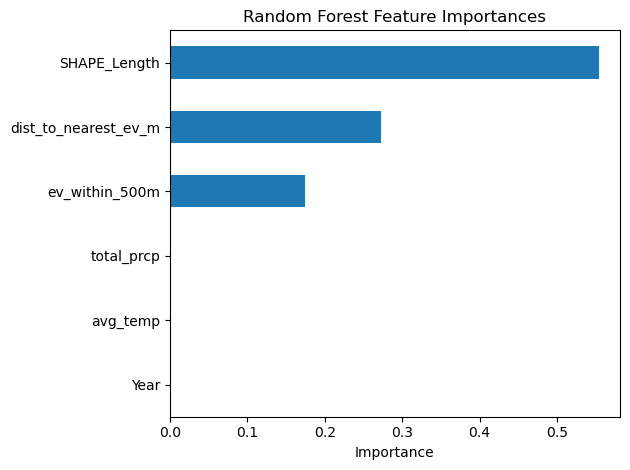

In [32]:
import matplotlib.pyplot as plt
# Feature Importances
importances = pd.Series(rf.feature_importances_, index=feature_cols)
importances.sort_values().plot(kind="barh")
plt.xlabel("Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()


#### Random Forest Regression with Hyperparameter Tuning 

In [34]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

,estimator,RandomForestRegressor()
,param_grid,"{'bootstrap': [True, False], 'max_depth': [None, 10, ...], 'min_samples_leaf': [1, 2], 'min_samples_split': [2, 5], ...}"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [39]:
print("Best Parameters:", grid_search.best_params_)
print("Best Estimator:", grid_search.best_estimator_)

Best Parameters: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best Estimator: RandomForestRegressor(max_depth=20, min_samples_leaf=2, min_samples_split=5)


In [41]:
# Pick the best model
best_rf = grid_search.best_estimator_
# Make a predict
y_pred_1 = best_rf.predict(X_test)

In [43]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred_1)  
rmse = np.sqrt(mse)                      
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.1f}")
print(f"R^2: {r2:.3f}")

RMSE: 3956.2
R^2: -0.078


In [49]:
y_pred

array([1172.905,  936.445,  866.6  , 3627.905, 5074.87 , 2947.475,
        741.305, 6630.94 ,  351.955, 1978.23 , 1154.9  ,  320.85 ,
        390.38 ,  336.17 , 4443.14 ,  484.195, 5541.33 , 1013.095,
       4188.255,  277.095, 1310.44 ,  338.5  , 2269.76 ,  827.985,
       1024.26 , 8791.735, 3193.685, 1983.715, 1881.67 ,  478.73 ,
       6180.46 , 3848.445,  488.63 , 1389.78 , 1819.915])

In [46]:
import joblib 
# save the model
joblib.dump(best_rf, "ev_model.pkl")
print("Model saved as ev_model.pkl")

Model saved as ev_model.pkl
